## Imports

In [1]:
import datetime
import gc
import math
import os
import pickle
import random
import sys
import time

import keras.backend as K
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import pylab as plt
import tensorflow as tf
from keras import regularizers
from keras.backend import squeeze
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.initializers import Constant, glorot_uniform, lecun_uniform
from keras.layers import (LSTM, BatchNormalization, Conv3D, ConvLSTM2D, Input,
                          Lambda, Reshape)
from keras.losses import (binary_crossentropy, mean_absolute_error,
                          mean_squared_error)
from keras.models import Model, Sequential
from keras.optimizers import Adadelta
from keras.utils import plot_model
from matplotlib import colorbar
from matplotlib.colors import ListedColormap, Normalize, from_levels_and_colors
from matplotlib.pyplot import savefig
from mpl_toolkits.axes_grid1 import AxesGrid, ImageGrid
from numpy.random import seed
from sklearn.metrics import (confusion_matrix, f1_score,
                             precision_recall_fscore_support, precision_score,
                             recall_score)
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow import set_random_seed

%matplotlib inline

print(os.listdir("../input/"))

Using TensorFlow backend.


# Config

In [2]:
# choose a number of time steps
steps = n_steps_in = n_steps_out = 8

# model config
batch_size = 64
n_epochs = 100
verbose = 1
patience = 10
restore_weights = True

# .fit_generator method needs to know how many time it has to call the generators during one epoch
fixed_batch_size = False

# Utils

In [3]:
# reduce memory usage by converting to proper data types
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out, batch_size):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = (
            sequences[i:end_ix, :, :, :],
            sequences[end_ix:out_end_ix, :, :, -1, np.newaxis],
        )
        X.append(seq_x)
        y.append(seq_y)
    size = (len(X) // batch_size) * batch_size
    return np.array(X[-size:]), np.array(y[-size:])


# plot train/val loss across the epochs
def plot_history(history, title="loss"):
    loss_list = [s for s in history.history.keys() if "loss" in s and "val" not in s]
    val_loss_list = [s for s in history.history.keys() if "loss" in s and "val" in s]

    if len(loss_list) == 0:
        print("Loss is missing in history")
        return

    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "b",
            label="Training loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )
    for l in val_loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "g",
            label="Validation loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()


# plot predictions and actuals
def plot_preds(
    preds,
    y_valid,
    num_preds=n_steps_out,
    valid=True,
    vmin=0.0,
    vmax=1.0,
    figsize=(6, 6),
):
    fig, axarr = plt.subplots(2, num_preds, figsize=figsize)
    for idx in range(num_preds):
        im = axarr[0, idx].imshow(
            preds[idx, :, :, 0], origin="lower", vmin=vmin, vmax=vmax, cmap=plt.cm.Reds
        )
        axarr[0, idx].set_title("Pred {}".format(idx + 1))
        if valid:
            im = axarr[1, idx].imshow(
                y_valid[idx, :, :, 0],
                origin="lower",
                vmin=vmin,
                vmax=vmax,
                cmap=plt.cm.Reds,
            )
            axarr[1, idx].set_title("Actual {}".format(idx + 1))

    fig.subplots_adjust(wspace=0.2, hspace=num_preds / 10)
    cax, kw = colorbar.make_axes([ax for ax in axarr.flat])
    plt.colorbar(im, cax=cax, **kw)
    plt.show()


def plot_single_cm(cm, ax, title):
    classes = ["No Fire", "Fire"]
    vmax = np.max(cm)
    im = ax.imshow(cm, vmin=0.0, vmax=vmax, cmap=plt.cm.Blues)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j]),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    return im, ax

# Load Data

In [4]:
dtype_dict = {
    "lat": np.float16,
    "lon": np.float16,
    "U2M": np.float16,
    "T2M": np.float16,
    "V50M": np.float16,
    "T10M": np.float16,
    "SLP": np.float32,
    "V2M": np.float16,
    "V10M": np.float16,
    "U50M": np.float16,
    "U10M": np.float16,
    "QV2M": np.float16,
    "QV10M": np.float16,
    "SPEEDMAX": np.float16,
    "BSTAR": np.float16,
    "PRECTOT": np.float16,
    "GWETTOP": np.float16,
    "LAI": np.float32,
    "GWETROOT": np.float32,
    "GRN": np.float32,
    "TSURF": np.float32,
    "EVI": np.float32,
    "MIR": np.float32,
    "EVI_wasNA": np.bool,
    "MIR_wasNA": np.bool,
    "fire_count": np.float16,
    "dayOfYear": np.int16,
    "dayOfWeek": np.int8,
    "population density": np.float16,
    "SGH": np.float16,
    "lat": np.float16,
    "lon": np.float16,
    "elevation": np.float16,
    "agriculture": np.float16,
    "forest": np.float16,
    "grassland": np.float16,
    "wetland": np.float16,
    "settlement": np.float16,
    "shrubland": np.float16,
    "sparse_veg": np.float16,
    "bare_area": np.float16,
    "water": np.float16,
}

In [5]:
pd.set_option("display.max_colwidth", 1000)  # set optins to show all columns

chunks = pd.read_csv(
    "../input/ibm-fire-dataset-builder-3-6-hr/basegrid_12h.csv",
    index_col=["timestamp", "lat", "lon"],
    chunksize=10e5,
    usecols=[
        "timestamp",
        "lat",
        "lon",
        "U2M",
        "T2M",
        "T10M",
        "SLP",
        "V2M",
        "V10M",
        "U10M",
        "QV2M",
        "QV10M",
        "BSTAR",
        "GWETTOP",
        "LAI",
        "GWETROOT",
        "GRN",
        "TSURF",
        "MIR",
        "population density",
        "SGH",
        "elevation",
        "agriculture",
        "forest",
        "grassland",
        "wetland",
        "settlement",
        "shrubland",
        "sparse_veg",
        "bare_area",
        "water",
        "PRECTOT",
        "sin_dayOfYear",
        "cos_dayOfYear",
        "fire_count",
    ],
)

df = pd.concat(chunk for chunk in chunks)

num_rows, num_cols = df.shape
num_rows, num_cols

(2233460, 32)

In [6]:
os.listdir("../input/ibm-fire-non-fire-input-data-conversion-to-pandas/")

['__results__.html',
 '__results___files',
 'start_2010-02-01_00h_step_12h_pred_noinputfire_th_min08853_colormax_min06308.csv',
 'start_2010-02-01_00h_step_12h_pred_noinputfire_shifted_to_zero_scaled_up_to_8.csv',
 '__notebook__.ipynb',
 '__output__.json',
 'custom.css']

In [7]:
nofire_df = pd.read_csv(
    "../input/"
    "ibm-fire-non-fire-input-data-conversion-to-pandas/"
    "start_2010-02-01_00h_step_12h_pred_noinputfire_shifted_to_zero_scaled_up_to_8.csv"
)

In [8]:
nofire_df.head()

,time,lat,lon,fire_potential
0,2010-02-01 00:00:00,32.5,-123.750,-2.228501
1,2010-02-01 00:00:00,32.5,-123.125,-2.781150
2,2010-02-01 00:00:00,32.5,-122.500,-2.945652
3,2010-02-01 00:00:00,32.5,-121.875,-2.371143
4,2010-02-01 00:00:00,32.5,-121.250,-3.545576


In [9]:
df = df.query('timestamp >= "2010-02-01 00:00:00"')

In [10]:
df["nofire_preds"] = nofire_df.loc[:, "fire_potential"].values

In [11]:
df.head()

U2M    T2M   T10M         SLP     V2M  \
timestamp           lat  lon                                                 
2010-02-01 00:00:00 32.5 -123.750  2.117  286.5  286.5  101656.870  1.3910   
                         -123.125  2.428  286.5  286.5  101659.945 -0.3367   
                         -122.500  2.793  286.5  286.2  101645.620 -1.9590   
                         -121.875  3.172  286.8  286.5  101625.340 -3.2700   
                         -121.250  3.188  286.8  286.5  101580.610 -3.9510   

                                     V10M   U10M      QV2M     QV10M  \
timestamp           lat  lon                                           
2010-02-01 00:00:00 32.5 -123.750  1.5390  2.324  0.007263  0.007020   
                         -123.125 -0.3608  2.660  0.007088  0.006836   
                         -122.500 -2.1640  3.082  0.007065  0.006780   
                         -121.875 -3.6660  3.553  0.007164  0.006832   
                         -121.250 -4.4840  3.620  0.007484  0.007175   

                                      BSTAR      ...       settlement  \
timestamp           lat  lon                     ...                    
2010-02-01 00:00:00 32.5 -123.750  0.002820      ...              0.0   
                         -123.125  0.002327      ...              0.0   
                         -122.500  0.002668      ...              0.0   
                         -121.875  0.002777      ...              0.0   
                         -121.250  0.002129      ...              0.0   

                                   shrubland  sparse_veg  bare_area  water  \
timestamp           lat  lon                                                 
2010-02-01 00:00:00 32.5 -123.750        0.0         0.0        0.0    1.0   
                         -123.125        0.0         0.0        0.0    1.0   
                         -122.500        0.0         0.0        0.0    1.0   
                         -121.875        0.0         0.0        0.0    1.0   
                         -121.250        0.0         0.0        0.0    1.0   

                                        PRECTOT  fire_count  sin_dayOfYear  \
timestamp           lat  lon                                                 
2010-02-01 00:00:00 32.5 -123.750  2.150000e-06       -20.0       0.523416   
                         -123.125  3.000000e-07       -20.0       0.523416   
                         -122.500  0.000000e+00       -20.0       0.523416   
                         -121.875  0.000000e+00       -20.0       0.523416   
                         -121.250  0.000000e+00       -20.0       0.523416   

                                   cos_dayOfYear  nofire_preds  
timestamp           lat  lon                                    
2010-02-01 00:00:00 32.5 -123.750       0.852078     -2.228501  
                         -123.125       0.852078     -2.781150  
                         -122.500       0.852078     -2.945652  
                         -121.875       0.852078     -2.371143  
                         -121.250       0.852078     -3.545576  

[5 rows x 33 columns]

In [12]:
cols = [x for x in df.columns if x not in ["fire_count", "nofire_preds"]]
cols.append("nofire_preds")
cols.append("fire_count")
df = df[cols]

In [13]:
df.head()

U2M    T2M   T10M         SLP     V2M  \
timestamp           lat  lon                                                 
2010-02-01 00:00:00 32.5 -123.750  2.117  286.5  286.5  101656.870  1.3910   
                         -123.125  2.428  286.5  286.5  101659.945 -0.3367   
                         -122.500  2.793  286.5  286.2  101645.620 -1.9590   
                         -121.875  3.172  286.8  286.5  101625.340 -3.2700   
                         -121.250  3.188  286.8  286.5  101580.610 -3.9510   

                                     V10M   U10M      QV2M     QV10M  \
timestamp           lat  lon                                           
2010-02-01 00:00:00 32.5 -123.750  1.5390  2.324  0.007263  0.007020   
                         -123.125 -0.3608  2.660  0.007088  0.006836   
                         -122.500 -2.1640  3.082  0.007065  0.006780   
                         -121.875 -3.6660  3.553  0.007164  0.006832   
                         -121.250 -4.4840  3.620  0.007484  0.007175   

                                      BSTAR     ...      settlement  \
timestamp           lat  lon                    ...                   
2010-02-01 00:00:00 32.5 -123.750  0.002820     ...             0.0   
                         -123.125  0.002327     ...             0.0   
                         -122.500  0.002668     ...             0.0   
                         -121.875  0.002777     ...             0.0   
                         -121.250  0.002129     ...             0.0   

                                   shrubland  sparse_veg  bare_area  water  \
timestamp           lat  lon                                                 
2010-02-01 00:00:00 32.5 -123.750        0.0         0.0        0.0    1.0   
                         -123.125        0.0         0.0        0.0    1.0   
                         -122.500        0.0         0.0        0.0    1.0   
                         -121.875        0.0         0.0        0.0    1.0   
                         -121.250        0.0         0.0        0.0    1.0   

                                        PRECTOT  sin_dayOfYear  cos_dayOfYear  \
timestamp           lat  lon                                                    
2010-02-01 00:00:00 32.5 -123.750  2.150000e-06       0.523416       0.852078   
                         -123.125  3.000000e-07       0.523416       0.852078   
                         -122.500  0.000000e+00       0.523416       0.852078   
                         -121.875  0.000000e+00       0.523416       0.852078   
                         -121.250  0.000000e+00       0.523416       0.852078   

                                   nofire_preds  fire_count  
timestamp           lat  lon                                 
2010-02-01 00:00:00 32.5 -123.750     -2.228501       -20.0  
                         -123.125     -2.781150       -20.0  
                         -122.500     -2.945652       -20.0  
                         -121.875     -2.371143       -20.0  
                         -121.250     -3.545576       -20.0  

[5 rows x 33 columns]

In [14]:
df.shape

(2213400, 33)

In [15]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 565.76 MB
Memory usage after optimization is: 152.03 MB
Decreased by 73.1%


In [16]:
gc.collect()

0

In [17]:
# set missing values to -1
df["fire_count"] = df["fire_count"].replace(-20, -1)

df["fire_count"].describe()

count    2213400.0
mean           NaN
std            0.0
min           -1.0
25%           -1.0
50%           -1.0
75%           -1.0
max          167.0
Name: fire_count, dtype: float64

# Preprocess Data

In [18]:
# scale the data
# separate scaler for labels to easily scale back later
scaler_features = StandardScaler()
scaler_label = StandardScaler()
df.loc[:, df.columns != "fire_count"] = scaler_features.fit_transform(
    df.loc[:, df.columns != "fire_count"]
)
df.loc[:, df.columns == "fire_count"] = scaler_label.fit_transform(
    df.loc[:, df.columns == "fire_count"]
)

In [19]:
df['fire_count'].describe()

count    2.213400e+06
mean     6.018168e-13
std      1.000000e+00
min     -7.718787e-02
25%     -7.718787e-02
50%     -7.718787e-02
75%     -7.718787e-02
max      2.122222e+02
Name: fire_count, dtype: float64

# Separate train, validation, test

In [20]:
df_test = df.query('timestamp >= "2018-01-01 00:00:00"')
df_valid = df.query(
    '(timestamp < "2018-01-01 00:00:00") & (timestamp >= "2017-01-01 00:00:00")'
)
df = df.query('timestamp < "2017-01-01 00:00:00"')

In [21]:
# how many timestep we have, this is going to be our first dim
dim_time_train = len(df.index.get_level_values(0).unique())
dim_time_test = len(df_test.index.get_level_values(0).unique())
dim_time_valid = len(df_valid.index.get_level_values(0).unique())
# how many lat we have
dim_lat = len(df.index.get_level_values(1).unique())
# how many lon we have
dim_lon = len(df.index.get_level_values(2).unique())
# how many features if 'fire_count' is feature, and not only label
features = len(df.columns)

print("Train Dimensions: {}, {}, {}".format(dim_time_train, dim_lat, dim_lon))
print("Validation Dimensions: {}, {}, {}".format(dim_time_valid, dim_lat, dim_lon))
print("Test Dimensions: {}, {}, {}".format(dim_time_test, dim_lat, dim_lon))
print("Features: ", features)

Train Dimensions: 5052, 20, 17
Validation Dimensions: 730, 20, 17
Test Dimensions: 728, 20, 17
Features:  33


In [22]:
# convert pandas to our properly dimensionalized numpy arrays
df_np_train = (
    df.copy().values.reshape((dim_time_train, dim_lat, dim_lon, -1)).astype(np.float32)
)
df_np_valid = (
    df_valid.copy()
    .values.reshape((dim_time_valid, dim_lat, dim_lon, -1))
    .astype(np.float32)
)
df_np_test = (
    df_test.copy()
    .values.reshape((dim_time_test, dim_lat, dim_lon, -1))
    .astype(np.float32)
)

In [23]:
# print out the shape
print(df_np_train.shape)
print(df_np_valid.shape)
print(df_np_test.shape)

(5052, 20, 17, 33)
(730, 20, 17, 33)
(728, 20, 17, 33)


In [24]:
# del df
# del df_valid
# del df_test
gc.collect()

33

# Semitemporal Generator test

In later kernels goes to utils, here I want to check and show it working.

In [25]:
def semitemp_generator(
    sequences, batch_size, semitemporal_ixs, temporal_ixs, steps, fixed_batch_size=False
):
    X, y = list(), list()
    is_end = False
    i = 0
    while i < (len(sequences)):
        # find the end of this pattern
        end_ix = i + steps
        # check if we are beyond the dataset
        if end_ix >= len(sequences):
            end_ix = len(sequences)
            is_end = True
        # gather input and output parts of the pattern
        seq_x = np.zeros_like(sequences[i:end_ix, :, :, :])
        seq_x[:, :, :, temporal_ixs] = sequences[i:end_ix, :, :, temporal_ixs]
        seq_x[:, :, :, semitemporal_ixs] = sequences[
            i : i + 1, :, :, semitemporal_ixs
        ]  # i:i+1 keeps dimensions
        seq_y = sequences[i:end_ix, :, :, -1:]
        X.append(seq_x)
        y.append(seq_y)
        i = i + 1
        # if we have our batch_size, or reached the end of data
        if ((len(X) > 0) and (len(X) % batch_size == 0)) or (is_end == True):
            # only yield if we use the not fixed batch size option, or have full batch
            if (fixed_batch_size == False) or (len(X) == batch_size):
                yield np.array(X[:]), np.array(y[:])
            X, y = list(), list()
            if is_end == True:
                i = 0
                is_end = False

In [26]:
pd.DataFrame(list(df_test.columns))

,0
0,U2M
1,T2M
2,T10M
3,SLP
4,V2M
5,V10M
6,U10M
7,QV2M
8,QV10M
9,BSTAR


In [27]:
# the indexes of temporals end semitemporals
semitemporal_ixs = [10, 11, 12, 13, 15, 32]
feature_ixs = [i for i in range(df_np_test.shape[3])]
temporal_ixs = list(set(feature_ixs) - set(semitemporal_ixs))

In [28]:
# instantiate the generator
generator = semitemp_generator(
    df_np_test,
    batch_size=30,
    semitemporal_ixs=semitemporal_ixs,
    temporal_ixs=temporal_ixs,
    steps=8,
    fixed_batch_size=False,
)

In [29]:
# generator test, when running this cell muliple times,
# it will generate some full batch and a remainder batch one after another infinite
print(next(generator)[0].shape)

(30, 8, 20, 17, 33)


In [30]:
# lets see a temporal:
print(next(generator)[0][0, :, 0, 0, 1])

[0.2715169  0.2715169  0.18865035 0.21627253 0.21627253 0.21627253
 0.21627253 0.07816166]


In [31]:
# lets see a semi-temporal:
print(next(generator)[0][0, :, 0, 0, 10])
print(next(generator)[0][0, 0, 0, 0, 10])

[1.7573775 1.7573775 1.7573775 1.7573775 1.7573775 1.7573775 1.7573775
 1.7573775]
1.7573775


# Define Model

In [33]:
def get_model(len_embed_cols, num_numeric_feats=features, filter_size=60):

    model_out = []
    model_in = []

    filter_size = filter_size
    kernel_size = (3, 3)
    kernel_size_3D = (3, 3, 3)
    recurrent_activation = "tanh"
    bias_initializer = Constant(value=1.0)
    kernel_initializer = glorot_uniform(seed=42)

    inputs = Input(
        shape=(steps, dim_lat, dim_lon, features), name="Input_num", dtype="float32"
    )

    outputs = ConvLSTM2D(
        filters=filter_size,
        kernel_size=kernel_size,
        padding="same",
        data_format="channels_last",
        # inputs will have the same shape except on the final dimension, which now has the added
        # embeddings, so we take the final dim merged
        input_shape=(steps, dim_lat, dim_lon, features),
        return_sequences=True,
        unit_forget_bias=True,
        bias_initializer=bias_initializer,
        recurrent_activation=recurrent_activation,
        go_backwards=False,
        recurrent_dropout=0.3,
        stateful=False,
    )(inputs)
    outputs = BatchNormalization()(outputs)
    outputs = ConvLSTM2D(
        filters=filter_size,
        kernel_size=kernel_size,
        padding="same",
        data_format="channels_last",
        return_sequences=True,
        unit_forget_bias=True,
        bias_initializer=bias_initializer,
        recurrent_activation=recurrent_activation,
        go_backwards=True,
        recurrent_dropout=0.3,
        stateful=False,
    )(outputs)

    outputs = BatchNormalization()(outputs)

    print("LSTM output:", outputs.shape)

    outputs = Conv3D(
        filters=1,
        kernel_size=kernel_size_3D,
        padding="same",
        kernel_initializer=kernel_initializer,
        activation=None,
        data_format="channels_last",
        kernel_regularizer=regularizers.l2(0.0001),
    )(outputs)
    print("CNN output:", outputs.shape)

    ## first inputs are all of the embedding layers, followed by the numeric feats
    model = Model([inputs], outputs)

    print(model.summary())
    # plot graph
    plot_model(model, to_file="network_functional_api.png")

    return model

In [34]:
# for ssim choose one of the following: ssim_bce, ssim_mse, ssim_mae, ssim_mse_mae
model = get_model(n_steps_in)
loss = "binary_crossentropy"
optimizer = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0, clipnorm=1.0)
model.compile(loss=loss, optimizer=optimizer)
model.summary()

LSTM output: (?, ?, 20, 17, 60)
CNN output: (?, ?, 20, 17, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_num (InputLayer)       (None, 8, 20, 17, 33)     0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 8, 20, 17, 60)     201120    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 20, 17, 60)     240       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 8, 20, 17, 60)     259440    
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 20, 17, 60)     240       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 20, 17, 1)      1621      
Total params: 462,661
Trainable params: 462,421
Non-trainable params: 240
______

# Setup training parameters

In [35]:
# set random seed for reproducibility
seed(42)
set_random_seed(42)
random.seed(42)

rLR = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

In [36]:
# instantiate the generators for training, validation and testing
gen_train = semitemp_generator(df_np_train, batch_size=batch_size, 
                               semitemporal_ixs=semitemporal_ixs, temporal_ixs=temporal_ixs, 
                               steps=steps)
gen_valid = semitemp_generator(df_np_valid, batch_size=batch_size, 
                               semitemporal_ixs=semitemporal_ixs, temporal_ixs=temporal_ixs, 
                               steps=steps)
gen_test = semitemp_generator(df_np_test, batch_size=batch_size, 
                              semitemporal_ixs=semitemporal_ixs, temporal_ixs=temporal_ixs, 
                              steps=steps)

In [37]:
if fixed_batch_size == False:
    steps_per_epoch = math.ceil((len(df_np_train) - (steps - 1)) / batch_size)
    validation_steps = math.ceil((len(df_np_valid) - (steps - 1)) / batch_size)
    test_steps = math.ceil((len(df_np_test) - (steps - 1)) / batch_size)
else:
    steps_per_epoch = (len(df_np_train) - (steps - 1)) // batch_size
    validation_steps = (len(df_np_valid) - (steps - 1)) // batch_size
    test_steps = (len(df_np_test) - (steps - 1)) // batch_size

print("steps_per_epoch: ", steps_per_epoch)
print("validation_steps: ", validation_steps)
print("test_steps: ", test_steps)

steps_per_epoch:  79
validation_steps:  12
test_steps:  12


Fit the model

In [38]:
H = model.fit_generator(
    generator=gen_train,
    steps_per_epoch=steps_per_epoch,
    epochs=n_epochs,
    validation_data=gen_valid,
    validation_steps=validation_steps,
    callbacks=[rLR],
)

Epoch 1/100
79/79 [==============================] - 19s 243ms/step - loss: 0.1819 - val_loss: -0.4437
Epoch 2/100
79/79 [==============================] - 14s 178ms/step - loss: -0.6511 - val_loss: -0.7240
Epoch 3/100
79/79 [==============================] - 14s 178ms/step - loss: -0.8325 - val_loss: -1.0551
Epoch 4/100
79/79 [==============================] - 14s 179ms/step - loss: -0.9259 - val_loss: -1.0926
Epoch 5/100
79/79 [==============================] - 14s 179ms/step - loss: -0.9520 - val_loss: -1.0958
Epoch 6/100
79/79 [==============================] - 14s 179ms/step - loss: -0.9962 - val_loss: -1.1569
Epoch 7/100
79/79 [==============================] - 14s 179ms/step - loss: -1.0113 - val_loss: -1.1525
Epoch 8/100
79/79 [==============================] - 14s 178ms/step - loss: -1.0182 - val_loss: -1.1379
Epoch 9/100
79/79 [==============================] - 14s 179ms/step - loss: -1.0279 - val_loss: -1.1461
Epoch 10/100
79/79 [==============================] - 14s 180ms/s

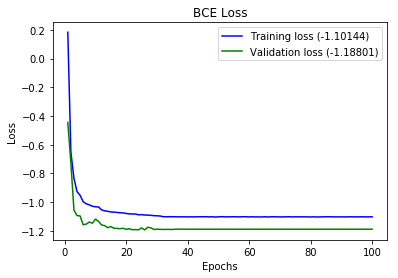

In [39]:
history = model.history
plot_history(history, title="BCE Loss")

In [41]:
with open("history_dict.pickle", "wb") as pkl:
    pickle.dump(history.history, pkl, protocol=pickle.HIGHEST_PROTOCOL)

# Make Prediction

In [42]:
fire_pred = model.predict_generator(generator=gen_test, steps=test_steps)
fire_pred.shape

(721, 8, 20, 17, 1)

# Inverse transform test data and prediction

In [43]:
# inverse transform prediction_data and test_data to original range
# drop unecessary dimensions for easier handling
fire_pred = scaler_label.inverse_transform(fire_pred)
fire_pred = fire_pred.squeeze()
fire_real = scaler_label.inverse_transform(df_np_test[:, :, :, -1])
print("fire_pred shape: ", fire_pred.shape)
print("fire_real shape: ", fire_real.shape)

fire_pred shape:  (721, 8, 20, 17)
fire_real shape:  (728, 20, 17)


# Make fire/non-fire separation

In [44]:
# make matrices where 1 is fire existence, zero is none existence
fire_count_threshold = 0
fire_pred_exist = (fire_pred > 0).astype(int)
fire_real_exist = (fire_real > 0).astype(int)

In [45]:
# convert the real data to the same shape as forecast for easier usage
# make a container with the shape of the forecasted data (which has steps, but observation doesnt)
extended_fire_real_exist = np.zeros_like(fire_pred_exist)
extended_fire_real = np.zeros_like(fire_pred)

In [46]:
# convert the observed fire to the same dims as prediction with steps calculated from a given starting time
for start_time in range(len(extended_fire_real_exist)):
    for i in range(steps):
        extended_fire_real_exist[start_time, i, :, :] = fire_real_exist[
            start_time + i, :, :
        ]
        extended_fire_real[start_time, i, :, :] = fire_real[start_time + i, :, :]

In [47]:
print(extended_fire_real.shape)
print(fire_pred.shape)

(721, 8, 20, 17)
(721, 8, 20, 17)


# Plot some examples

In [48]:
def plot_fires_from(start_step, steps=[0, 1], figsize=(10, 8), vmin=0, vmax=1):
    """
    From the starting step of the numpy arrays first dim (which is time) plots
    figures for every step of the forecast determined in the steps list.
    """
    f, axarr = plt.subplots(4, len(steps), figsize=figsize)
    for i, st in enumerate(steps):
        axarr[0, i].imshow(
            fire_pred[start_step, i, :, :], origin="lower", cmap="nipy_spectral"
        )
        axarr[0, i].set_title("Pr full {}".format(st))
        axarr[1, i].imshow(
            fire_pred[start_step, i, :, :],
            origin="lower",
            vmin=vmin,
            vmax=vmax,
            cmap="nipy_spectral",
        )
        axarr[1, i].set_title("Pr thres {}".format(st))
        axarr[2, i].imshow(
            fire_pred_exist[start_step, i, :, :],
            origin="lower",
            vmin=vmin,
            vmax=vmax,
            cmap="nipy_spectral",
        )
        axarr[2, i].set_title("Pr exst {}".format(st))
        axarr[3, i].imshow(
            extended_fire_real[start_step, i, :, :],
            origin="lower",
            vmin=vmin,
            vmax=vmax,
            cmap="nipy_spectral",
        )
        axarr[3, i].set_title("Act {}".format(st))

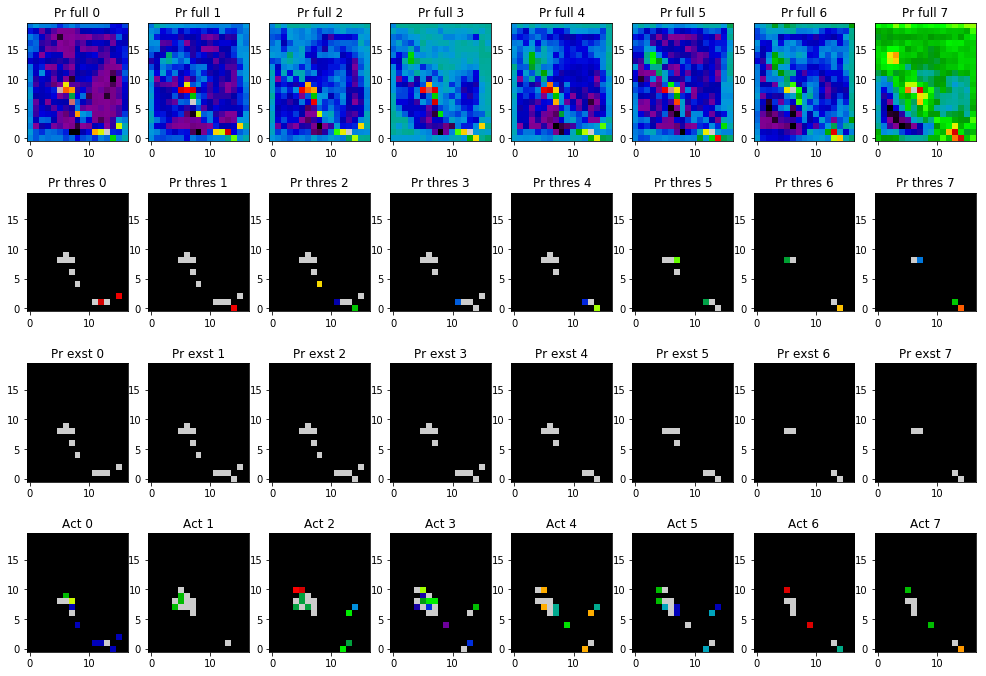

In [49]:
# as we have only 4 steps now I want to show every steps, so in steps=[] we
# determine the steps to show
# lets see from the 50th day of the year (we are on 12h steps, so 2*)
plot_fires_from(50, steps=[0, 1, 2, 3, 4, 5, 6, 7], figsize=(17, 12))

# Calculate the scores

## Full forecast period scores

In [50]:
confusion_matrix(
    fire_pred_exist[:, :, :, :].flatten(),
    extended_fire_real_exist[:, :, :, :].flatten(),
)

array([[1888717,   31055],
       [  15223,   26125]])

In [51]:
precision_recall_fscore_support(
    fire_pred_exist[:, 0:3, :, :].flatten(),
    extended_fire_real_exist[:, 0:3, :, :].flatten(),
)

(array([0.99415128, 0.74876272]),
 array([0.9924763 , 0.79340029]),
 array([0.99331308, 0.77043549]),
 array([715207,  20213]))

## Last step score
During the forecast period we would like to forecast the changes of the fires. The first steps arent so important, as they are colse, and can be very stationary. The most important steps in real time are the later steps. Here we calculate the scores only for the last step of the forecast.

In [52]:
confusion_matrix(
    fire_pred_exist[:, -1, :, :].flatten(),
    extended_fire_real_exist[:, -1, :, :].flatten(),
)

array([[236376,   5687],
       [  1608,   1469]])

In [53]:
precision_recall_fscore_support(
    fire_pred_exist[:, -1, :, :].flatten(),
    extended_fire_real_exist[:, -1, :, :].flatten(),
)

(array([0.99324324, 0.20528228]),
 array([0.97650612, 0.47741306]),
 array([0.98480357, 0.28711033]),
 array([242063,   3077]))

# Prepare the validaiton predictions

In [54]:
fire_pred = model.predict_generator(generator=gen_valid, steps=validation_steps)
fire_pred = scaler_label.inverse_transform(fire_pred)
fire_pred = fire_pred.squeeze()
fire_pred_exist = (fire_pred > 0).astype(int)

with open("fire_pred_exist.pickle", "wb") as pkl:
    pickle.dump(fire_pred_exist, pkl, protocol=pickle.HIGHEST_PROTOCOL)

In [55]:
fire_pred.shape

(723, 8, 20, 17)

In [56]:
fire_count = []
for i in range(len(fire_pred)):
    fire_count.append(fire_pred_exist[i, :, :, :].sum())

In [57]:
# pick single prediction start timestamp
pred_idx = np.argmax(fire_count)
print(pred_idx)
valid_prediction = fire_pred_exist[pred_idx, :, :, :]

626


In [58]:
df_valid.shape, df_np_valid.shape, valid_prediction.shape

((248200, 33), (730, 20, 17, 33), (8, 20, 17))

In [59]:
time_zero = df_valid.reset_index().timestamp.unique()[pred_idx + 7]
print(time_zero)

dt = datetime.datetime.strptime(time_zero, "%Y-%m-%d %H:%M:%S")
step = datetime.timedelta(hours=12)
dates = [(dt + i * step) for i in range(valid_prediction.shape[0])]

lat = [
    32.5,
    33.0,
    33.5,
    34.0,
    34.5,
    35.0,
    35.5,
    36.0,
    36.5,
    37.0,
    37.5,
    38.0,
    38.5,
    39.0,
    39.5,
    40.0,
    40.5,
    41.0,
    41.5,
    42.0,
]
lon = [
    -123.75,
    -123.125,
    -122.5,
    -121.875,
    -121.25,
    -120.625,
    -120.0,
    -119.375,
    -118.75,
    -118.125,
    -117.5,
    -116.875,
    -116.25,
    -115.625,
    -115.0,
    -114.375,
    -113.75,
]

iterables = [dates, lat, lon]
index = pd.MultiIndex.from_product(iterables, names=["time", "lat", "lon"])

valid_prediction_df = pd.DataFrame(valid_prediction.flatten(), index=index)
valid_prediction_df.reset_index(inplace=True)

valid_prediction_df = valid_prediction_df.rename(columns={0: "fire_count"})

print(valid_prediction_df["time"].unique())

2017-11-13 12:00:00
['2017-11-13T12:00:00.000000000' '2017-11-14T00:00:00.000000000'
 '2017-11-14T12:00:00.000000000' '2017-11-15T00:00:00.000000000'
 '2017-11-15T12:00:00.000000000' '2017-11-16T00:00:00.000000000'
 '2017-11-16T12:00:00.000000000' '2017-11-17T00:00:00.000000000']


In [60]:
valid_prediction_df.fire_count.sum()

172

In [61]:
print(valid_prediction_df.fire_count.sum())
valid_sample = scaler_label.inverse_transform(
    df_np_valid[pred_idx : pred_idx + 7, :, :, -1]
)
valid_sample = (valid_sample > 0).astype(int)
print(valid_sample.sum())

172
71


In [62]:
valid_prediction_df.to_csv(
    "valid_prediction_{}.csv".format(time_zero[:10]), index=False
)